In [25]:
import pandas as pd
import gzip
import matplotlib.pyplot as plt
import seaborn as sns

### Download files and print them

In [11]:
# Specify the file paths
activity_file = 'vaud_activities.csv.gz'
population_file = 'vaud_population.csv.gz'
trip_file = 'vaud_trips.csv.gz'

# Read the gzipped CSV files
def read_gzipped_csv(file_path):
    with gzip.open(file_path, 'rt') as file:
        df = pd.read_csv(file)
    return df

# Read the dataframes
activity_df = read_gzipped_csv(activity_file)
population_df = read_gzipped_csv(population_file)
trip_df = read_gzipped_csv(trip_file)

In [12]:
print("Activity Data:")
print(activity_df.info())
print(activity_df.head())

Activity Data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4455006 entries, 0 to 4455005
Data columns (total 9 columns):
 #   Column      Dtype  
---  ------      -----  
 0   Unnamed: 0  int64  
 1   id          int64  
 2   type        object 
 3   facility    object 
 4   link        object 
 5   x           float64
 6   y           float64
 7   start_time  object 
 8   end_time    object 
dtypes: float64(2), int64(2), object(5)
memory usage: 305.9+ MB
None
   Unnamed: 0       id     type    facility    link          x          y  \
0      423464  1069770     home  home480932  399007  2569239.0  1190194.0   
1      423465  1069770     shop      168569  244909  2571696.0  1189601.0   
2      423466  1069770     home  home480932  399007  2569239.0  1190194.0   
3      423467  1069770  leisure      399230  399013  2569430.0  1189314.0   
4      423468  1069770     home  home480932  399007  2569239.0  1190194.0   

  start_time  end_time  
0        NaN  09:23:32  
1   09:25:32  09

In [13]:
print("Population Data:")
print(population_df.info())
print(population_df.head())

Population Data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 825564 entries, 0 to 825563
Data columns (total 25 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                825564 non-null  int64  
 1   age               825564 non-null  int64  
 2   bikeAvailability  825564 non-null  object 
 3   carAvail          825564 non-null  object 
 4   employed          825564 non-null  bool   
 5   hasLicense        825564 non-null  object 
 6   home_x            825564 non-null  float64
 7   home_y            825564 non-null  float64
 8   householdIncome   0 non-null       float64
 9   isCarPassenger    825564 non-null  bool   
 10  municipalityType  0 non-null       float64
 11  ptHasGA           825564 non-null  bool   
 12  ptHasHalbtax      825564 non-null  bool   
 13  ptHasStrecke      825564 non-null  bool   
 14  ptHasVerbund      825564 non-null  bool   
 15  sex               825564 non-null  object 
 16  spR

In [14]:
print("Trip Data:")
print(trip_df.info())
print(trip_df.head())

Trip Data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3629442 entries, 0 to 3629441
Data columns (total 12 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   Unnamed: 0        int64 
 1   id                int64 
 2   mode              object
 3   dep_time          object
 4   trav_time         object
 5   start_link        object
 6   end_link          object
 7   transitRouteId    object
 8   boardingTime      object
 9   transitLineId     object
 10  accessFacilityId  object
 11  egressFacilityId  object
dtypes: int64(2), object(10)
memory usage: 332.3+ MB
None
   Unnamed: 0       id  mode  dep_time trav_time start_link end_link  \
0      345939  1069770  walk  09:23:32  00:45:38     399007   244909   
1      345940  1069770  walk  10:09:10  00:45:38     244909   399007   
2      345941  1069770  walk  10:54:48  00:16:15     399007   399013   
3      345942  1069770  walk  11:11:03  00:16:15     399013   399007   
4      354968  1071953   car  15:24:50

### Analyses the files

##### 1) Activities

In [69]:
activity_df.groupby('type')['facility'].count().head(10)

type
education          138568
home              1906623
leisure            419003
other              235921
pt interaction          0
shop               263958
work               444575
Name: facility, dtype: int64

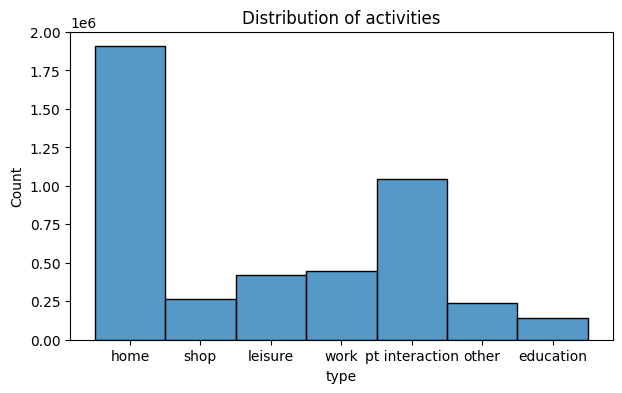

In [32]:
plt.figure(figsize=(7,4))
sns.histplot(activity_df['type'])
plt.title('Distribution of activities')
plt.show()

In [70]:
def count_facilities_in_local(activity_df, local, population_df):
    # Find the coordinate range corresponding to the specified local
    local_df = population_df[population_df['local'] == local]
    min_x, max_x = local_df['home_x'].min(), local_df['home_x'].max()
    min_y, max_y = local_df['home_y'].min(), local_df['home_y'].max()
    
    # Filter the activity_df using the coordinate range
    filtered_df = activity_df[(activity_df['x'] >= min_x) & (activity_df['x'] <= max_x) &
                              (activity_df['y'] >= min_y) & (activity_df['y'] <= max_y)]
    
    # Count the number of facilities per type inside the coordinate range
    count_df = filtered_df.groupby('type')['facility'].count().reset_index()
    count_df.columns = ['Facility Type', 'Count']
    
    return count_df

In [91]:
localities = population_df.groupby(['local']).count()['id'].sort_values(ascending=False).head(5).index
for local in localities:
    count_df = count_facilities_in_local(activity_df, local, population_df)
    print(f"\nHere's the count of facilities by types in {local} :")
    print(count_df)


Here's the count of facilities by types in Lausanne :
    Facility Type   Count
0       education   34085
1            home  433579
2         leisure   78156
3           other   40320
4  pt interaction       0
5            shop   56145
6            work  132032

Here's the count of facilities by types in Cheseaux-Noréaz :
    Facility Type  Count
0       education   7127
1            home  79726
2         leisure  11850
3           other   6886
4  pt interaction      0
5            shop   9310
6            work  16011

Here's the count of facilities by types in Renens VD :
    Facility Type  Count
0       education   4470
1            home  79853
2         leisure  12637
3           other   6660
4  pt interaction      0
5            shop  10006
6            work  15735

Here's the count of facilities by types in Nyon :
    Facility Type  Count
0       education   6288
1            home  53234
2         leisure   8390
3           other   4608
4  pt interaction      0
5            shop 

##### 2) Population of Vaud

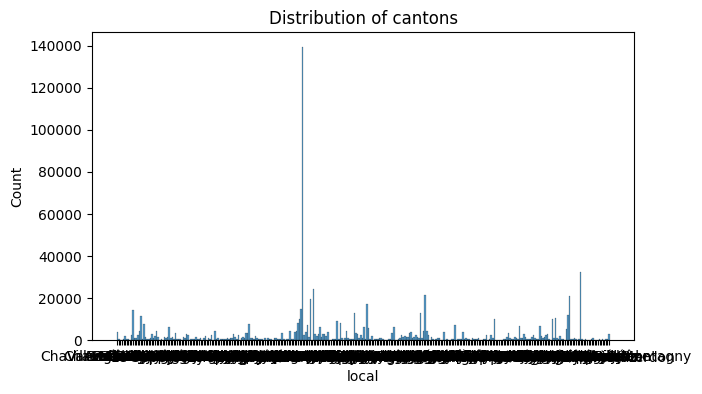

In [54]:
plt.figure(figsize=(7,4))
sns.histplot(population_df['local'])
plt.title('Distribution of cantons')
plt.show()

In [64]:
print("Count in local : \n")
print(population_df.groupby(['local']).count()['id'].sort_values(ascending=False).head(10))
print("\nCount in municipality :")
population_df.groupby(['municipality']).count()['id'].sort_values(ascending=False).head(10)
# 2e resultat est bizarre
# sinon c'est tjrs un peu over estimating mais coherent

Count in local : 

local
Lausanne              139392
Cheseaux-Noréaz        32372
Renens VD              24196
Nyon                   21597
Vevey                  21217
Pully                  19718
Morges                 17443
Jouxtens-Mézery        14887
Chavannes-des-Bois     14506
Gland                  13016
Name: id, dtype: int64

Count in municipality :


municipality
Lausanne              142041
Cheseaux-Noréaz        32372
Montreux               26761
Renens (VD)            24196
Nyon                   21597
Vevey                  21217
Pully                  19887
Morges                 17443
Jouxtens-Mézery        14887
Chavannes-des-Bois     14506
Name: id, dtype: int64

In [59]:
# Viewing unique values for each column
print("Unique Postcodes: ", population_df['postcode'].nunique())
print("Unique Locals: ", population_df['local'].nunique())
print("Unique Municipalities: ", population_df['municipality'].nunique())

# Viewing some samples to understand the relationship
print(population_df[['postcode', 'local', 'municipality']].drop_duplicates().head())


Unique Postcodes:  321
Unique Locals:  314
Unique Municipalities:  251
    postcode                 local          municipality
0       1580              Avenches              Avenches
9       1085              Vulliens              Vulliens
14      1584      Villars-le-Grand        Vully-les-Lacs
79      1512  Chavannes-sur-Moudon  Chavannes-sur-Moudon
86      1612              Ecoteaux                  Oron


In [65]:
population_df['age'].mean().round()

42.0

##### 3) Trips